# Imports and Functions

In [52]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from osgeo import gdal

import os
import glob
import random

from skimage.metrics import structural_similarity as ssim
from sewar.full_ref import rmse, psnr, uqi, ergas, scc, rase, sam, vifp

In [53]:
#gloabl variables
global channels 
channels = ['Coastal Aerosol','Blue','Green',
                 'Red','Red Edge 1','Red Edge 2',
                'Red Edge 3','NIR','Red Edge 4',
                 'Water Vapour','SWIR 1','SWIR 2',
                 "NDWI", "MNDWI","AWEI","WI"]

In [103]:
# Functions
def get_rgb(img):
    """Return normalized RGB channels from sentinal image"""
    
    rgb_img = img[:, :, [3,2,1]]
    rgb_normalize = np.clip(rgb_img/10000, 0, 0.3)/0.3
    
    return rgb_normalize

def load_test(path):
    """Returns sentinal image, rgb image and label"""
    
    img = gdal.Open(path).ReadAsArray()
    stack_img = np.stack(img, axis=-1)

    rgb_img = get_rgb(stack_img)
    
    label_path = path.replace("images","labels").replace("image","label")
    label = gdal.Open(label_path).ReadAsArray()
    
    return stack_img, rgb_img, label

def add_indices(img):
    """Add NDWI, MNDWI,AWEI, WI indices to image"""
    
    img = np.array(img)

    NDWI = (img[:,:,7]-img[:,:,2])/(img[:,:,7]+img[:,:,2])
    NDWI = np.nan_to_num(NDWI)

    MNDWI = (img[:,:,2]-img[:,:,10])/(img[:,:,2]+img[:,:,10])
    MNDWI =np.nan_to_num(MNDWI)

    AWEI = img[:,:,1] + 2.5*img[:,:,2] -1.5*(img[:,:,7] + img[:,:,10]) -0.25*img[:,:,11]
    
    WI = 1.7204 + 171*img[:,:,2] +171*img[:,:,3] - 70*img[:,:,7] -45*img[:,:,10] -71*img[:,:,11]
    
    img = np.dstack((img,NDWI,MNDWI,AWEI,WI))

    #print(np.min(NDWI),np.min(img[:,:,7]+img[:,:,2]), np.min(MNDWI), np.min((img[:,:,2]+img[:,:,10]) ))
    
    return img

    
def channel_filter(img,c=0):
    """Returns given channel from image"""
    img = np.array(img)
    c_img = img[:, :, c]

    return c_img


def plot_channels(img,invert=False,path=None):
    
    """Plot all channels of a given image"""
    
    global channels

    fig, axs = plt.subplots(4,4,figsize=(15,15))

    index = 0
    for i in range(4):
        for j in range(4):
            c_img = channel_filter(img,c=index)
            if invert:
                c_img = 255-c_img

            axs[i,j].imshow(c_img,cmap='gray')
            axs[i,j].set_title(channels[index],size=20)
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

            index +=1

    if path != None:
        plt.savefig(path,bbox_inches='tight')

# Get input and labels

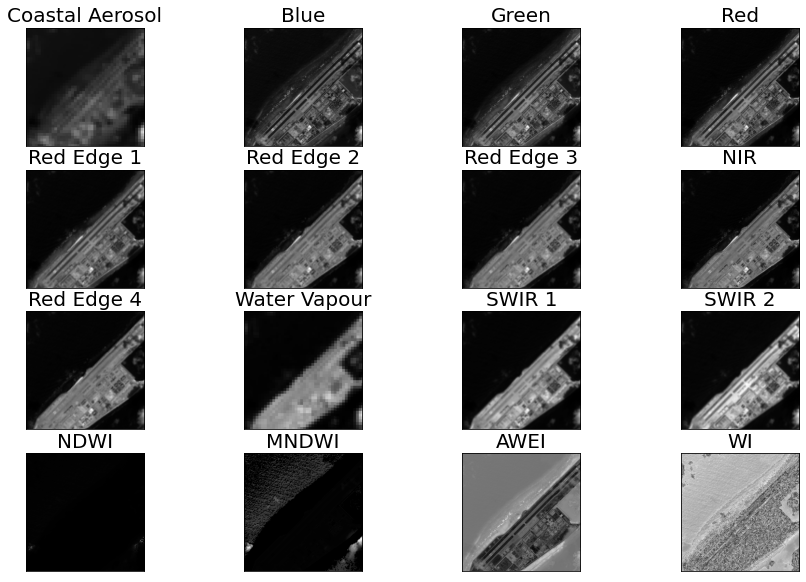

In [63]:
path = "../../data/SWED/test/images/S2A_MSIL2A_20191118T025011_N0213_R132_T49PGL_20191118T082459_image_0_0.tif"
img, rgb_img, label = load_test(path)
img = add_indices(img)
plot_channels(img)

In [64]:
test_path = glob.glob("../../data/SWED/test/images/*")
print(test_path[0])
print(len(test_path))

# Load all images
input = []
rgb = []
labels = []

for path in test_path:
    try:
        img, rgb_img, label = load_test(path)
        img = add_indices(img)
    
        input.append(img)
        labels.append(label)
        rgb.append(rgb_img)
    except:
        print("Error with image: ", path)

# Apply canny to binary maps
canny_input = [np.uint8(img*255) for img in labels]
edge_reference = [np.uint8(cv2.Canny(img,threshold1 = 100, threshold2 = 200)) for img in canny_input]

../../data/SWED/test/images/S2A_MSIL2A_20191105T023901_N0213_R089_T50RPN_20191105T062756_image_0_0.tif
98


/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_58702/2636045919.py:28: RuntimeWarning: invalid value encountered in true_divide
  NDWI = (img[:,:,7]-img[:,:,2])/(img[:,:,7]+img[:,:,2])
/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_58702/2636045919.py:31: RuntimeWarning: invalid value encountered in true_divide
  MNDWI = (img[:,:,2]-img[:,:,10])/(img[:,:,2]+img[:,:,10])


In [65]:
#Sense checks
print("Lengths:",len(input), len(labels), len(rgb), len(edge_reference))

print("Input:", np.min(input[0]),np.max(input[0]))
print("RGB:", np.min(rgb[0]),np.max(rgb[0]))
print(len(rgb[0][0][0]))
print("Labels:",np.min(labels[0]),np.max(labels[0]))
print("Edge reference:",np.min(edge_reference),np.max(edge_reference))


Lengths: 98 98 98 98
Input: -182407.2796 106893.72039999999
RGB: 0.05 1.0
3
Labels: 0 1
Edge reference: 0 255


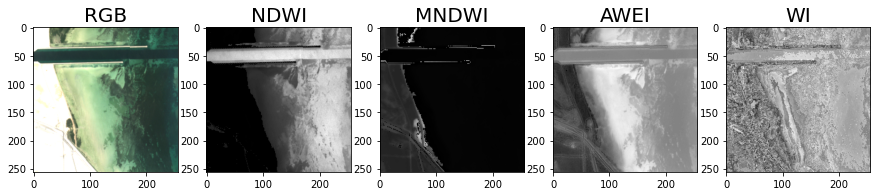

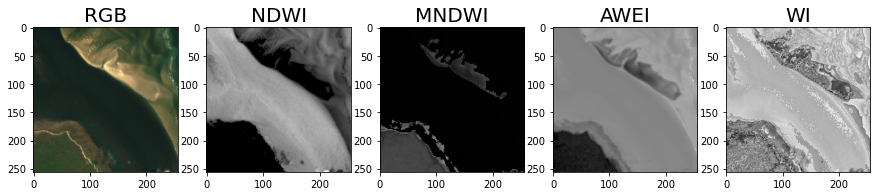

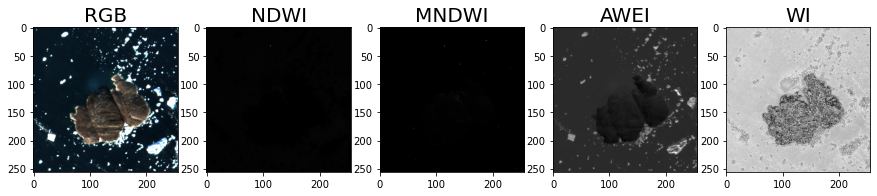

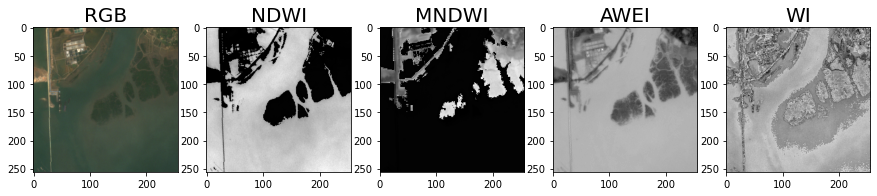

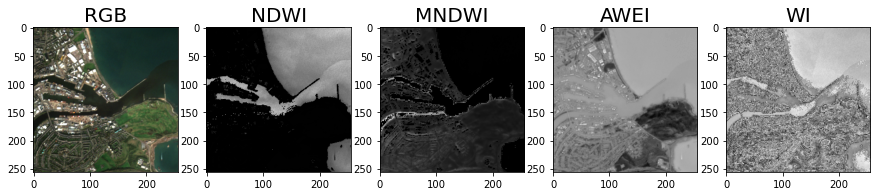

In [69]:
for j in range(5):
    # Plot NDWI, MNDWI,AWEI, WI indices

    i = random.randint(0,len(input))

    fig, axs = plt.subplots(1,5,figsize=(15,10))

    axs[0].imshow(rgb[i])
    axs[0].set_title("RGB",size=20)

    axs[1].imshow(channel_filter(input[i],c=12),cmap='gray')
    axs[1].set_title("NDWI",size=20)

    axs[2].imshow(channel_filter(input[i],c=13),cmap='gray')
    axs[2].set_title("MNDWI",size=20)

    axs[3].imshow(channel_filter(input[i],c=14),cmap='gray')
    axs[3].set_title("AWEI",size=20)

    axs[4].imshow(channel_filter(input[i],c=15),cmap='gray')
    axs[4].set_title("WI",size=20)


93


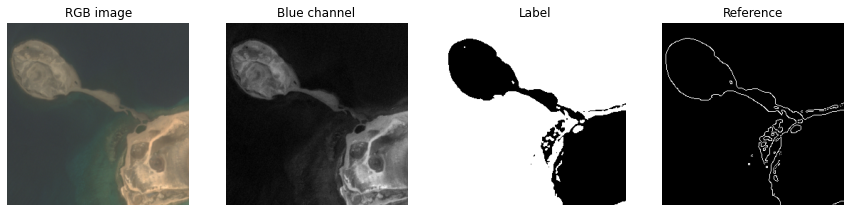

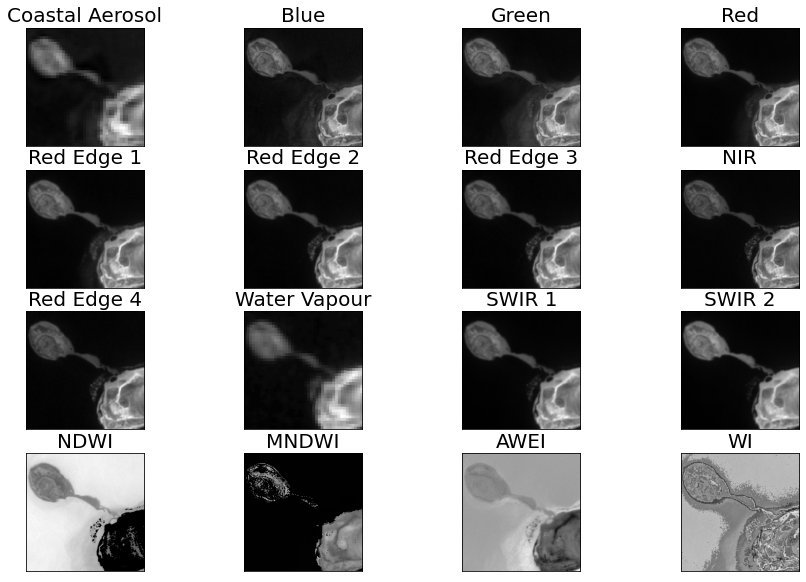

In [70]:
# View an image 
rint = random.randint(0,98)
print(rint)

fig, axs = plt.subplots(1,4, figsize=(15,15))

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB image")
axs[0].axis("off")

axs[1].imshow(input[rint][:,:,1],cmap="gray")
axs[1].set_title("Blue channel")
axs[1].axis("off")

axs[2].imshow(labels[rint],cmap="gray")
axs[2].set_title("Label")
axs[2].axis("off")

axs[3].imshow(edge_reference[rint],cmap="gray")
axs[3].set_title("Reference")
axs[3].axis("off")

plot_channels(input[rint])

# Edge detection

In [71]:
def preprocess(img_input, toggle=[True,True,True]):
        """Preprocess image for edge detection
        toggle: [Equalized histogram, Gaussian blur, Morphological closing]
        """
        img = img_input.copy()
        img = np.array(img)

        # Iterate over bands
        for i in range(16):
                img_i = img[:,:,i]

                # Scale bands between 0 and 255
                img[:,:,i] = cv2.normalize(img[:,:,i], None, 0, 255, cv2.NORM_MINMAX)

                # Equalized histogram
                img_i = np.uint8(img_i)
                if toggle[0]:
                        img_i = cv2.equalizeHist(img_i)


                # Gaussian blur
                if toggle[1]:
                        kernel = (5, 5)
                        img_i = cv2.GaussianBlur(img_i, kernel,0)

                # Morphological closing
                if toggle[2]:
                        kernel = np.ones((5,5),np.uint8)
                        img_i = cv2.morphologyEx(img_i, cv2.MORPH_CLOSE, kernel)
                
                img[:,:,i] = img_i
       
        img = np.uint8(img)
        return img

def canny_ed(img_input, threshold1=100, threshold2=200):

    #Apply canny edge detection to image
    img = img_input.copy()
    img = np.array(img)

    for i in range(16):
        img_i = img[:,:,i]
        img_i = cv2.Canny(img_i,threshold1 = threshold1, threshold2 = threshold2)
        img[:,:,i] = img_i

    return img


def scharr_ed(img_input):
    #Apply scharr edge detection to image
    img = img_input.copy()
    img = np.array(img)

    for i in range(16):
        img_i = img[:,:,i]
        schx = cv2.Scharr(img_i, cv2.CV_8U,1,0)
        schy = cv2.Scharr(img_i, cv2.CV_8U,0,1)
        scharr_img = schx + schy

        img[:,:,i] = scharr_img

    return img

def sobel_ed(img_input):
    #Apply sobel edge detection to image
    img = img_input.copy()
    img = np.array(img)

    for i in range(16):
        img_i = img[:,:,i]
        sobelx = cv2.Sobel(img_i, cv2.CV_8U,1,0,ksize=5)
        sobely = cv2.Sobel(img_i, cv2.CV_8U,0,1,ksize=5)
        sobel_img = sobelx + sobely

        img[:,:,i] = sobel_img

    return img    

def prewitt_ed(img_input):
    #Apply prewitt edge detection to image
    img = img_input.copy()
    img = np.array(img)

    for i in range(16):
        img_i = img[:,:,i]
        kx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]]) 
        ky = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
        prewittx = cv2.filter2D(img_i, -1, kx)
        prewitty = cv2.filter2D(img_i, -1, ky)
        prewitt_img = prewittx + prewitty

        img[:,:,i] = prewitt_img

    return img

In [72]:
# Preprocess images
preprocess_input = input.copy()
preprocess_input = [preprocess(img,toggle=[True,True,False]) for img in preprocess_input]

# Apply edge detection
canny = [canny_ed(img) for img in preprocess_input]
scharr = [scharr_ed(img) for img in preprocess_input]
sobel = [sobel_ed(img) for img in preprocess_input]
prewitt = [prewitt_ed(img) for img in preprocess_input]

74


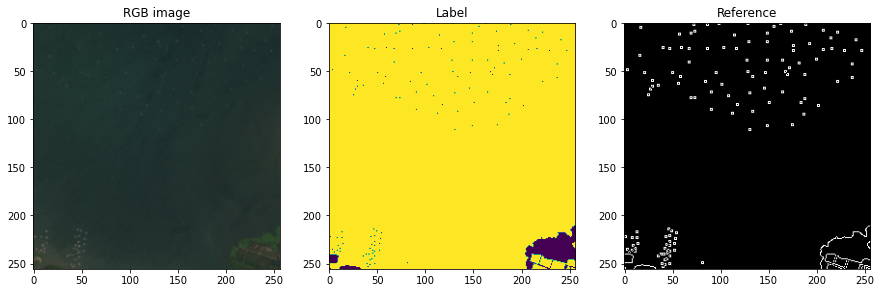

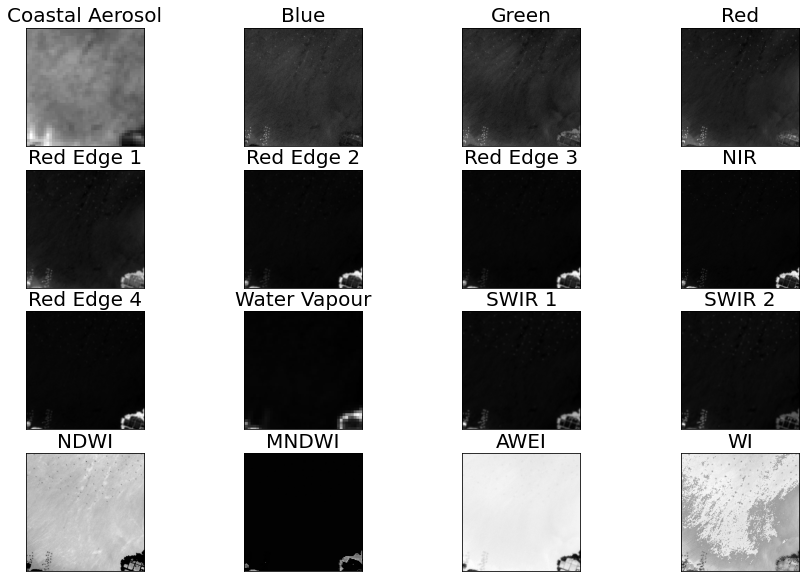

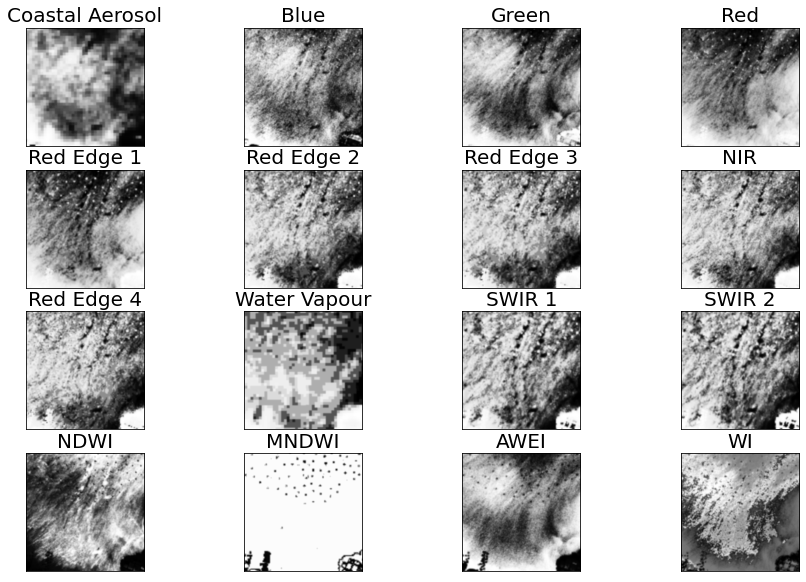

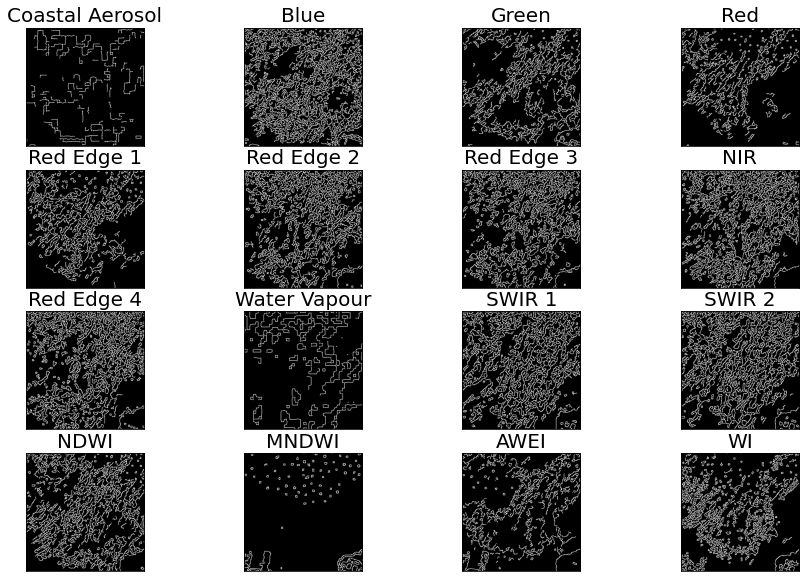

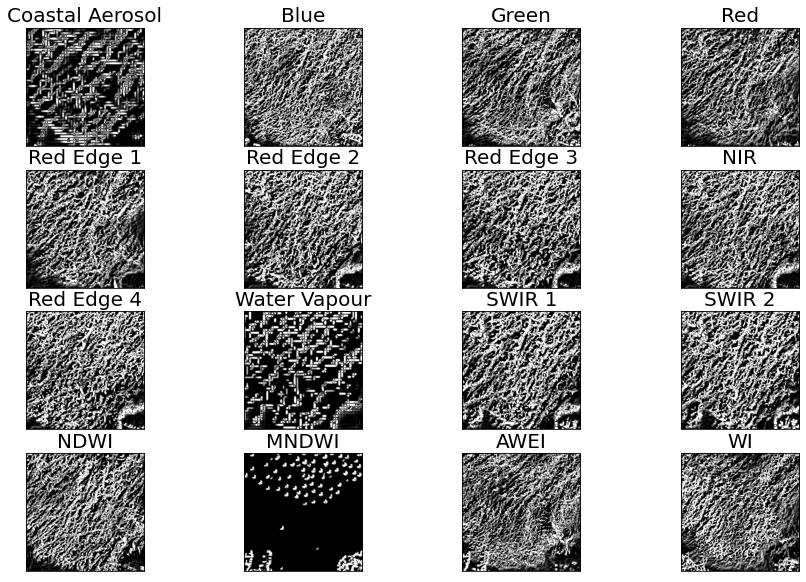

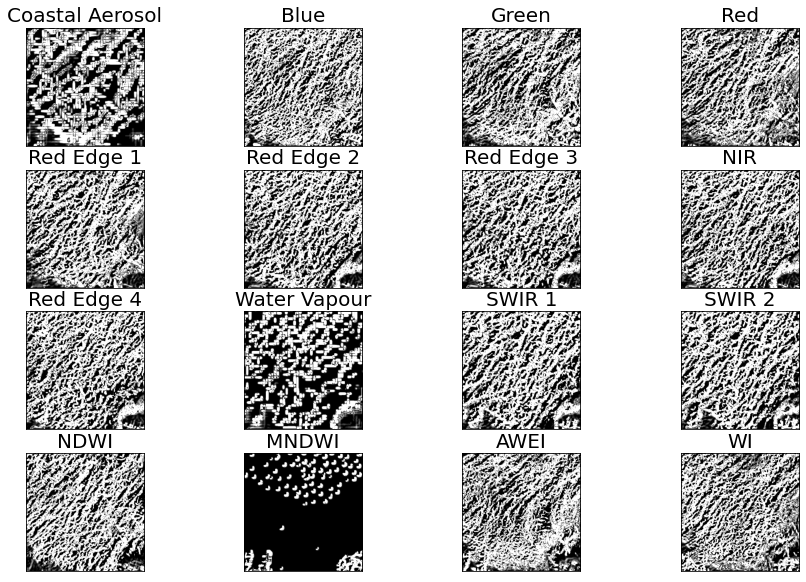

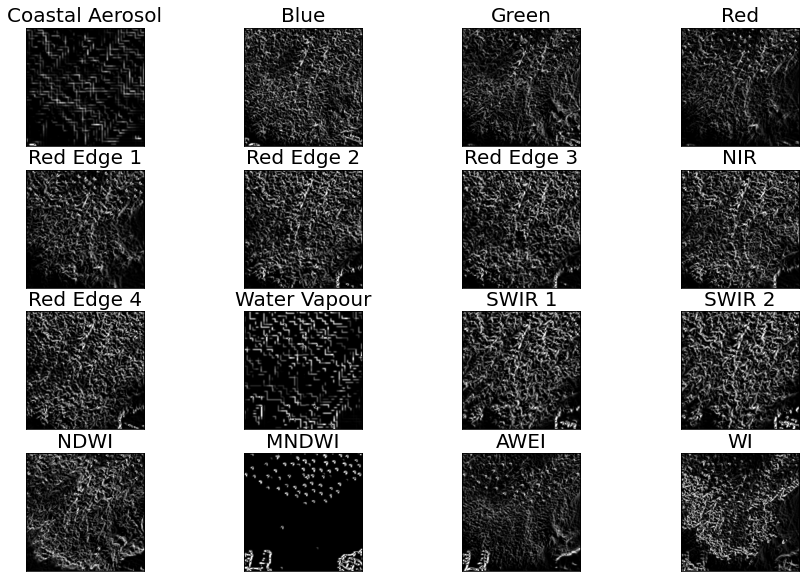

In [73]:
# Visualize edge detection
rint = random.randint(0,98)
print(rint)
fig, axs = plt.subplots(1,3, figsize=(15,15))

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB image")

axs[1].imshow(labels[rint])
axs[1].set_title("Label")

axs[2].imshow(edge_reference[rint],cmap="gray")
axs[2].set_title("Reference")

plot_channels(input[rint])

plot_channels(preprocess_input[rint])

plot_channels(canny[rint])

plot_channels(scharr[rint])

plot_channels(sobel[rint])

plot_channels(prewitt[rint])

# Calculate Metrics

In [75]:
def metrics(toggle=[True,True,False]):
    """Calculate metrics
    toggle: [Equalized histogram, Gaussian blur, Morphological closing]"""

    preprocess_input = input.copy()
    preprocess_input = [preprocess(img,toggle=toggle) for img in preprocess_input]

    canny = [canny_ed(img) for img in preprocess_input]
    scharr = [scharr_ed(img) for img in preprocess_input]
    sobel = [sobel_ed(img) for img in preprocess_input]
    prewitt = [prewitt_ed(img) for img in preprocess_input]

    rows = []
    for i in range(len(edge_reference)):
        ref_img = edge_reference[i]
        ID = "IMG#{}".format(i)
        
        for j in range(16):

            for method in ['canny','sobel','scharr','prewitt']:

                if method == 'canny':
                    img = canny[i][:,:,j]
                elif method == 'sobel':
                    img = sobel[i][:,:,j]
                elif method == 'scharr':
                    img = scharr[i][:,:,j]
                elif method == 'prewitt':
                    img = prewitt[i][:,:,j]

                rmse_ = rmse(ref_img,img)
                psnr_ = psnr(ref_img,img)
                uqi_ = uqi(ref_img,img)
                ssim_ = ssim(ref_img,img,multichannel=True)
                ergas_ = ergas(ref_img,img)
                scc_ = scc(ref_img,img)
                sam_ = sam(ref_img,img)
                vifp_ = vifp(ref_img,img)

                row = [ID,j+1,method,rmse_,psnr_,uqi_,ssim_,ergas_,scc_,sam_,vifp_]
                rows.append(row)
        
    df_metrics = pd.DataFrame(rows,columns = ['ID',"band","method","rmse","psnr","uqi","ssim","ergas","scc","sam","vifp"])
    return df_metrics

In [77]:
# With equalized histogram, Gaussian blur
df_metrics = metrics()
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all_indices.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_58702/1551531200.py:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)
/Users/conorosullivan/opt/miniconda3/envs/pytorch/lib/python3.10/site-packages/sewar/full_ref.py:270: RuntimeWarning: invalid value encountered in double_scalars
  val = np.clip(np.dot(GT[:,i],P[:,i]) / (np.linalg.norm(GT[:,i])*np.linalg.norm(P[:,i])),-1,1)


ID  band   method        rmse       psnr       uqi      ssim  \
0  IMG#0     1    canny   62.753906  12.177988  0.604987  0.759762   
1  IMG#0     1    sobel  154.552115   4.349305  0.058370  0.158417   
2  IMG#0     1   scharr  102.188274   7.942782  0.068414  0.200732   
3  IMG#0     1  prewitt   54.781079  13.358192  0.053571  0.288360   
4  IMG#0     2    canny   96.739115   8.418761  0.357888  0.523875   

          ergas       scc       sam      vifp  
0  22630.392331  0.001505  1.496337  0.011703  
1  42437.754220  0.000422  1.442221  0.007209  
2  29575.770504  0.001305  1.451472  0.008146  
3  20137.196443  0.001906  1.464758  0.009617  
4  26348.126423  0.016182  1.418941  0.030922

In [80]:
# With equalized histogram, Morphological closing
df_metrics = metrics(toggle=[True,False,True])
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_morph_indices.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_58702/1551531200.py:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)


ID  band   method        rmse       psnr       uqi      ssim  \
0  IMG#0     1    canny   79.068765  10.170705  0.436057  0.627644   
1  IMG#0     1    sobel  147.074710   4.780044  0.083691  0.243768   
2  IMG#0     1   scharr  103.611722   7.822626  0.116548  0.362353   
3  IMG#0     1  prewitt   61.450865  12.360244  0.091977  0.387225   
4  IMG#0     2    canny   80.738913   9.989146  0.420995  0.630314   

          ergas       scc       sam      vifp  
0  26502.383795  0.000391  1.495191  0.010792  
1  40577.365218  0.002319  1.458149  0.005920  
2  30348.049795 -0.001261  1.487266  0.006061  
3  21803.262083 -0.000645  1.487633  0.008346  
4  25017.951774  0.012092  1.404126  0.036163

In [81]:
# With equalized histogram
df_metrics = metrics(toggle=[True,False,False])
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_hist_indices.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_58702/1551531200.py:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)


ID  band   method        rmse       psnr       uqi      ssim  \
0  IMG#0     1    canny   79.525470  10.120679  0.434030  0.624517   
1  IMG#0     1    sobel  147.597566   4.749220  0.081306  0.240382   
2  IMG#0     1   scharr  104.056974   7.785380  0.114015  0.359223   
3  IMG#0     1  prewitt   61.561930  12.344559  0.087467  0.381359   
4  IMG#0     2    canny  120.823339   6.487787  0.190743  0.336512   

          ergas       scc       sam      vifp  
0  26729.171195  0.000292  1.494806  0.011017  
1  40748.964457  0.002315  1.458163  0.005963  
2  30486.526279 -0.000905  1.486091  0.006197  
3  21849.900285 -0.000294  1.487018  0.008380  
4  32405.241859  0.025023  1.415734  0.029840

In [82]:
# With gaussian blur
df_metrics = metrics(toggle=[False,True,False])
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_blur_indices.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_58702/1551531200.py:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)
/Users/conorosullivan/opt/miniconda3/envs/pytorch/lib/python3.10/site-packages/sewar/full_ref.py:270: RuntimeWarning: invalid value encountered in double_scalars
  val = np.clip(np.dot(GT[:,i],P[:,i]) / (np.linalg.norm(GT[:,i])*np.linalg.norm(P[:,i])),-1,1)


ID  band   method        rmse       psnr       uqi      ssim  \
0  IMG#0     1    canny   47.885077  14.526800  0.738014  0.852717   
1  IMG#0     1    sobel  126.702331   6.075112  0.065342  0.183769   
2  IMG#0     1   scharr   83.042629   9.744782  0.079569  0.254195   
3  IMG#0     1  prewitt   46.350852  14.809649  0.050002  0.414473   
4  IMG#0     2    canny   48.246323  14.461519  0.735176  0.852272   

          ergas       scc       sam      vifp  
0  19224.283084  0.001229  1.553902  0.000397  
1  34466.492970  0.000591  1.452468  0.006900  
2  24549.135115  0.000231  1.480166  0.006567  
3  18399.774882  0.000795  1.496859  0.007311  
4  18859.395663  0.002056  1.545739  0.000170

# Visualise metrics

In [83]:
def metric_bar(df,metric,save=False):
    """Plot bar chart of given metric for each edge detection method and band"""
    global channels 

    fig,ax = plt.subplots(1,1,figsize=(15,5))

    mean = df.groupby(["method","band"],as_index=False).mean()
    sd = df.groupby(["method","band"],as_index=False).std()

    edge_methods = ["canny","sobel","scharr","prewitt"]
    for i,em in enumerate(edge_methods):

        bands = mean[mean["method"]==em]["band"]
        em_mean = mean[mean["method"]==em][metric]
        em_sd = sd[sd["method"]==em][metric]

        w = 0.4
        plt.bar(bands-w/2+i*w/2,em_mean,yerr=em_sd,width=w/2,label=em)


    plt.ylabel(metric.upper(),fontsize=20)
    plt.xticks(ticks=range(1,17),labels= channels,fontsize=15, rotation=90)

    plt.legend()
    if save:
        plt.savefig("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/figures/{}_BAR.png".format(metric),bbox_inches='tight')

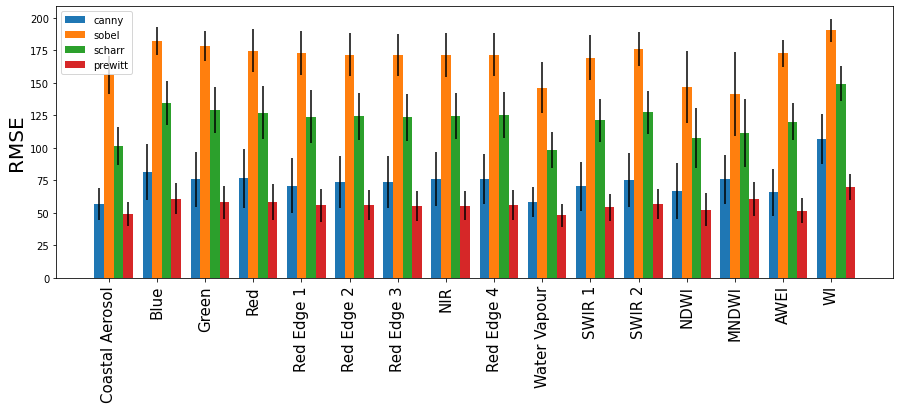

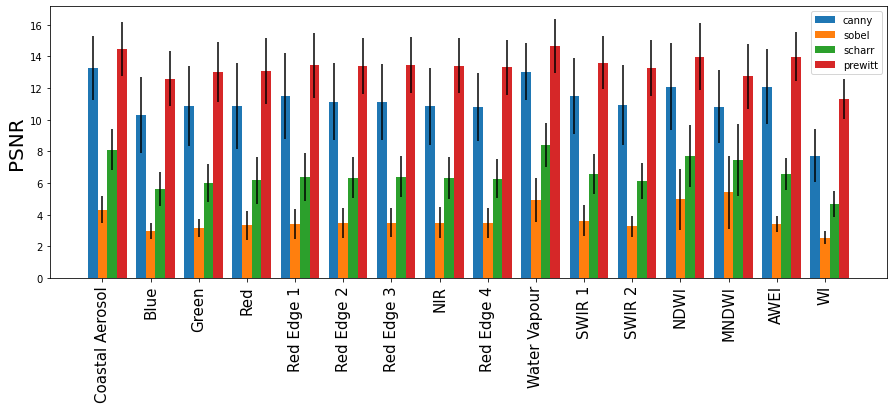

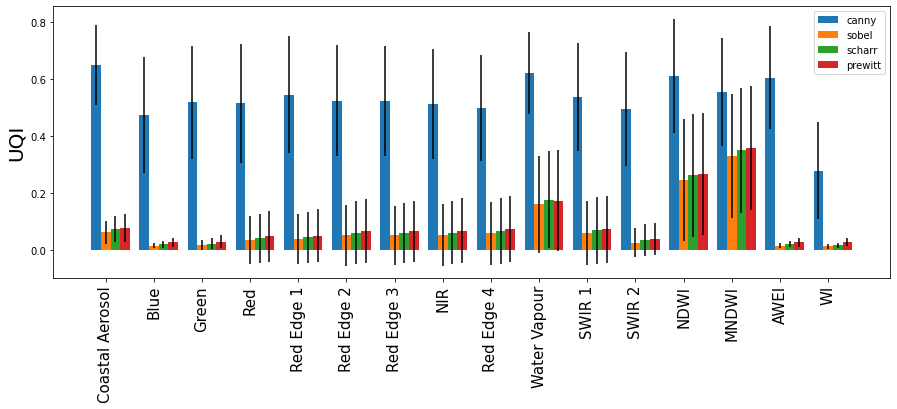

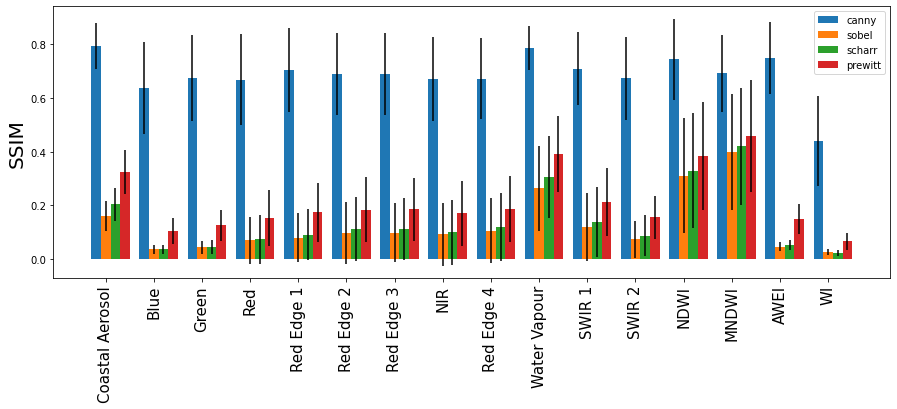

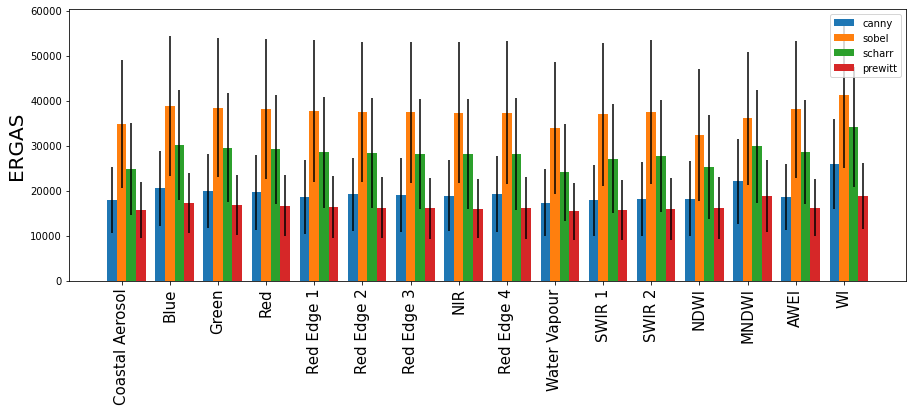

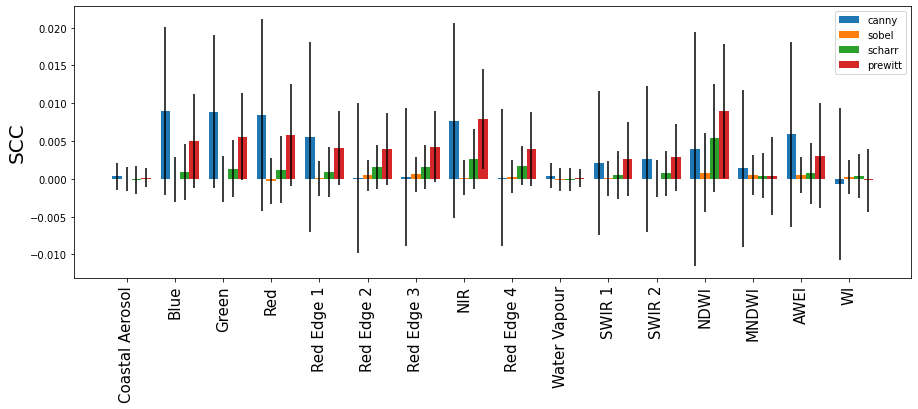

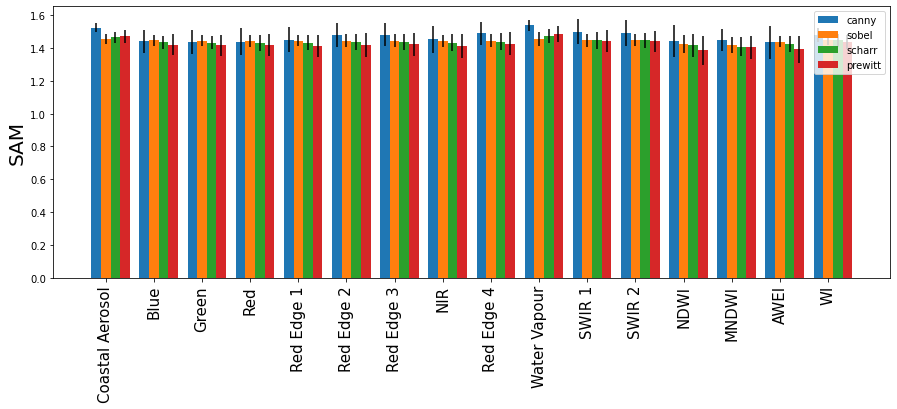

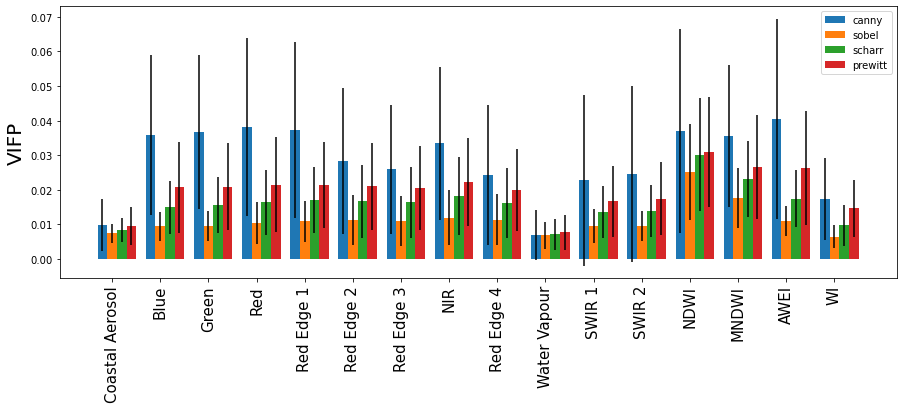

In [84]:
df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all_indices.csv",index_col=0)

metric_bar(df_metrics,'rmse',save=True)
metric_bar(df_metrics,'psnr',save=True)
metric_bar(df_metrics,'uqi')
metric_bar(df_metrics,'ssim',save=True)
metric_bar(df_metrics,'ergas')
metric_bar(df_metrics,'scc')
metric_bar(df_metrics,'sam',save=True)
metric_bar(df_metrics,'vifp')

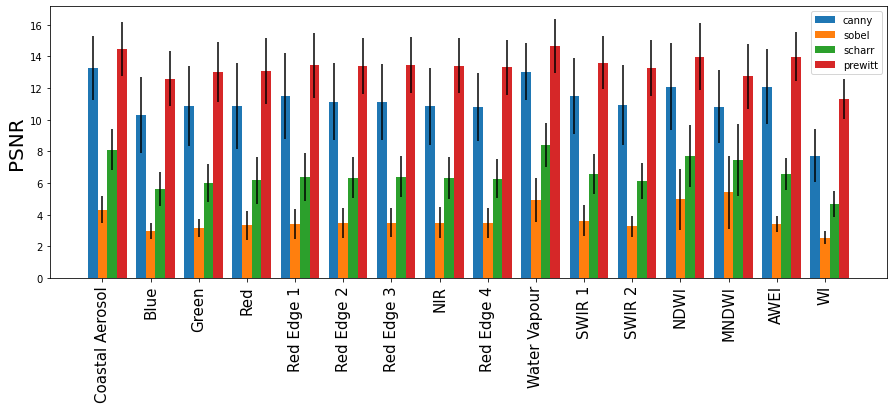

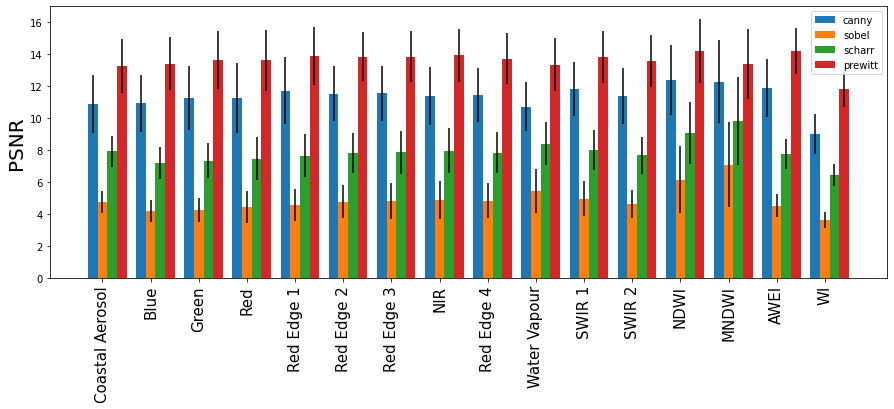

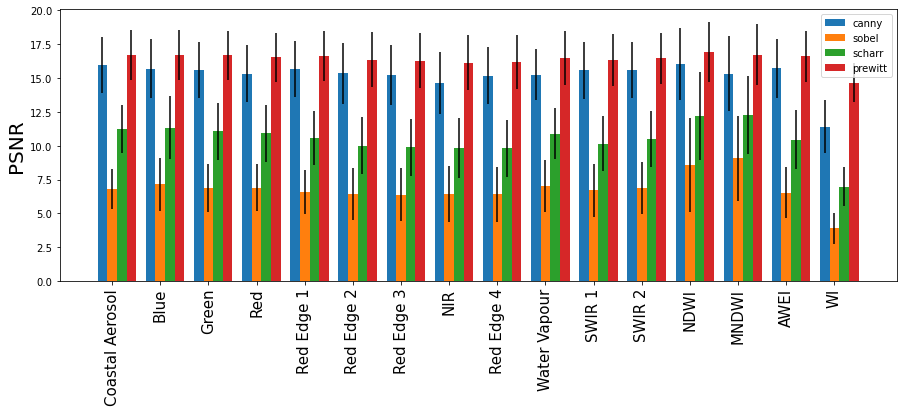

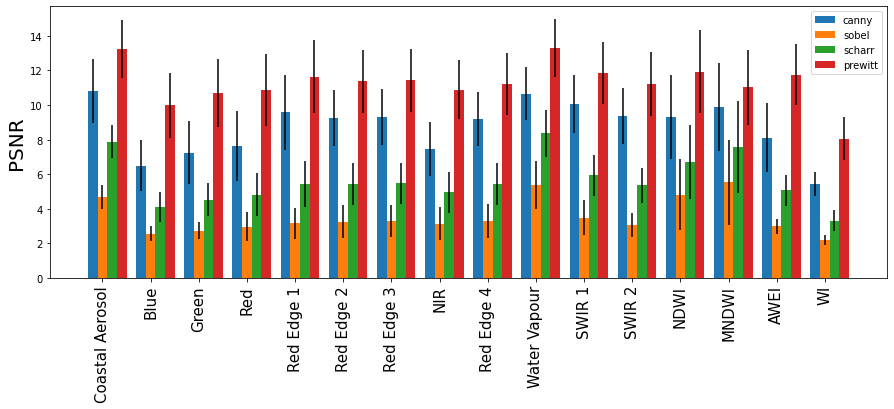

In [85]:
df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all_indices.csv",index_col=0)
metric_bar(df_metrics,'psnr')

df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_morph_indices.csv",index_col=0)
metric_bar(df_metrics,'psnr')

df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_blur_indices.csv",index_col=0)
metric_bar(df_metrics,'psnr')

df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_hist_indices.csv",index_col=0)
metric_bar(df_metrics,'psnr')


# Figures for paper 

In [93]:
save_path = "/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/figures/{}"

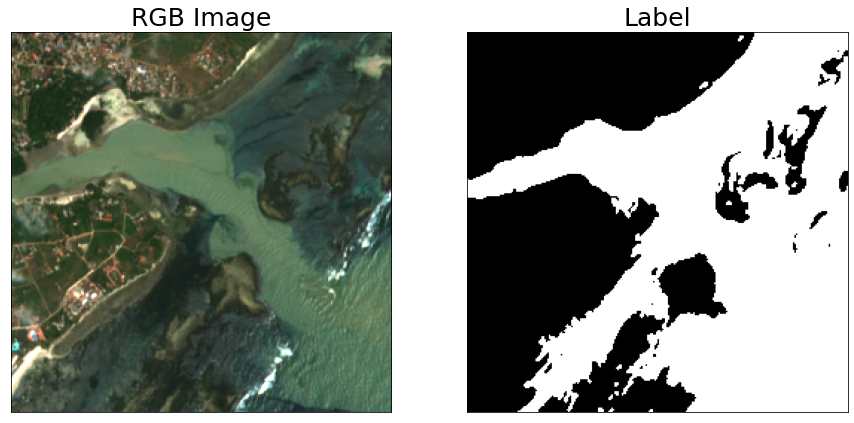

In [14]:
#Fig. 1. Example of a test image and label
rint = 90
fig, axs = plt.subplots(1,2, figsize=(15,15))

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB Image",size=25)

axs[1].imshow(labels[rint],cmap="gray")
axs[1].set_title("Label",size=25)
rint +=1

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig(save_path.format("text_example"),bbox_inches='tight')

35


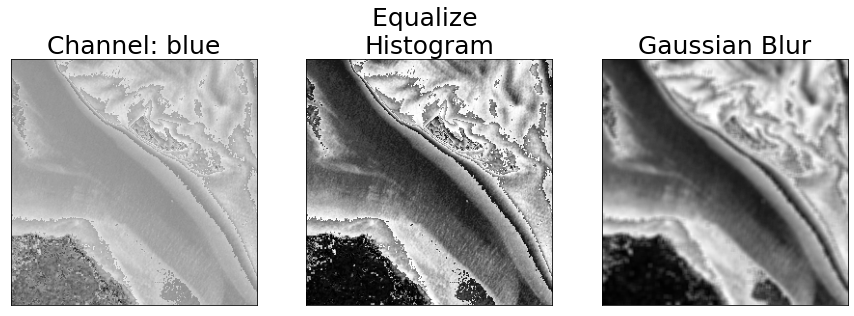

In [32]:
#Fig. 2. Example of pre-processing steps using blue band
rint = random.randint(0,98)
fig, axs = plt.subplots(1,3, figsize=(15,15))
print(rint)
rint = 2

#Get blue channel
img = channel_filter(input[rint],c=15)

# Original
axs[0].imshow(img,cmap="gray")
axs[0].set_title("Channel: blue",size=25)

# Scale bands between 0 and 255
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
img = np.uint8(img)

# Histogram Equalization
img = cv2.equalizeHist(img)
axs[1].imshow(img,cmap="gray")
axs[1].set_title("Equalize \nHistogram",size=25)

# Gaussian Blur
kernel = (5,5)
img = cv2.GaussianBlur(img, kernel,cv2.BORDER_DEFAULT)
axs[2].imshow(img,cmap="gray")
axs[2].set_title("Gaussian Blur",size=25)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

#plt.savefig(save_path.format("preprocessing.png"),bbox_inches='tight')

51


NameError: name 'save_path' is not defined

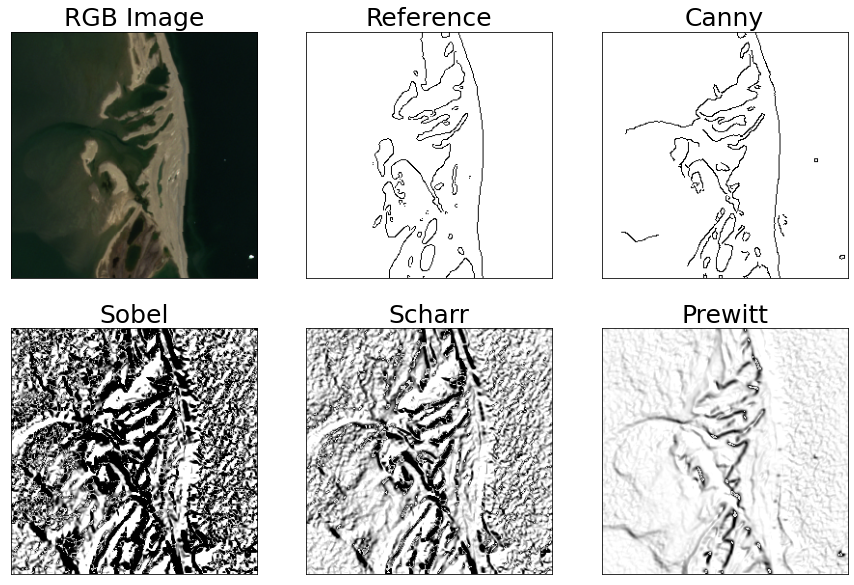

In [33]:
#Fig. 3. Edge detection algorithms applied to blue band
rint = random.randint(0,98)
fig, axs = plt.subplots(2,3, figsize=(15,10))
print(rint)
rint = 7

channel = 1

axs[0,0].imshow(rgb[rint])
axs[0,0].set_title("RGB Image",size=25)

axs[0,1].imshow(255-edge_reference[rint],cmap="gray")
axs[0,1].set_title("Reference",size=25)

axs[0,2].imshow(255-canny[rint][:,:,channel],cmap="gray")
axs[0,2].set_title("Canny",size=25)

axs[1,0].imshow(255-sobel[rint][:,:,channel],cmap="gray")
axs[1,0].set_title("Sobel",size=25)

axs[1,1].imshow(255-scharr[rint][:,:,channel],cmap="gray")
axs[1,1].set_title("Scharr",size=25)

axs[1,2].imshow(255-prewitt[rint][:,:,channel],cmap="gray")
axs[1,2].set_title("Prewitt",size=25)

for ax1 in axs:
    for ax in ax1:
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig(save_path.format("edge_detection.png"),bbox_inches='tight')

0


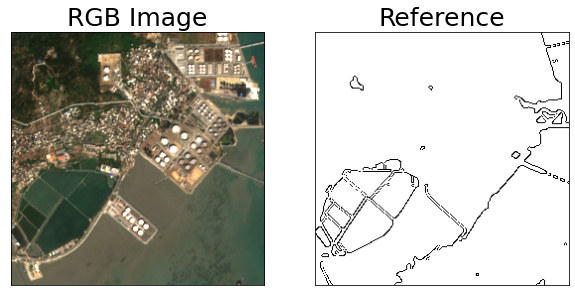

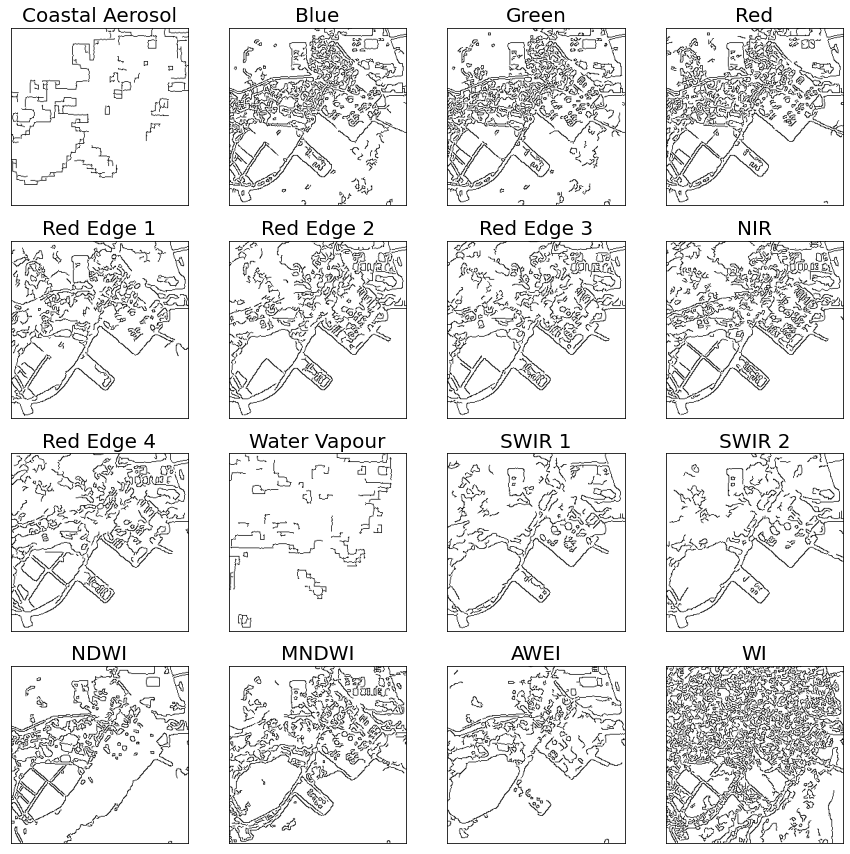

In [104]:
# Fig. 4. Image with non-coastal edges
preprocess_input = input.copy()
preprocess_input = [preprocess(img,toggle=[True,True,False]) for img in preprocess_input]

canny = [canny_ed(img) for img in preprocess_input]

rint = 0
fig, axs = plt.subplots(1,2, figsize=(10,15))
print(rint)

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB Image",size=25)

axs[1].imshow(255-edge_reference[rint],cmap="gray")
axs[1].set_title("Reference",size=25)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig(save_path.format("details.png"),bbox_inches='tight')

#Fig. 5. Edge detection applied to all channels
plot_channels(canny[rint],invert=True,path=save_path.format("details_all_channels.png"))

In [105]:
# Table 1: Metrics for all images
# Create in excel
df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all_indices.csv",index_col=0)

mean_all = df_metrics.groupby(["method","band"],as_index=False).mean()

all_stats = mean_all[mean_all["method"]=="canny"][['psnr',"ssim"]]
all_stats.columns = ['canny_psnr_mn',"canny_ssim_mn"]

for method in ["sobel","scharr","prewitt"]:
    all_stats[method+"_psnr_mn"] = np.array(mean_all[mean_all["method"]==method]["psnr"])
    all_stats[method+"_ssim_mn"] = np.array(mean_all[mean_all["method"]==method]["ssim"])

std_all = df_metrics.groupby(["method","band"],as_index=False).std()

for method in ["canny","sobel","scharr","prewitt"]:
    all_stats[method+"_psnr"] = np.array(std_all[std_all["method"]==method]["psnr"])
    all_stats[method+"_ssim"] = np.array(std_all[std_all["method"]==method]["ssim"])

all_stats.to_clipboard()
all_stats

canny_psnr_mn  canny_ssim_mn  sobel_psnr_mn  sobel_ssim_mn  \
0       13.248667       0.795187       4.324894       0.158839   
1       10.265769       0.636835       2.958641       0.036572   
2       10.865771       0.674604       3.129318       0.044223   
3       10.864941       0.668683       3.335634       0.069211   
4       11.507565       0.704612       3.416213       0.079947   
5       11.129753       0.689588       3.481511       0.098374   
6       11.116444       0.689517       3.499239       0.098678   
7       10.829926       0.672558       3.506002       0.091761   
8       10.788720       0.672936       3.483813       0.105609   
9       13.023163       0.785284       4.922463       0.263041   
10      11.481092       0.708626       3.613039       0.119216   
11      10.921471       0.673998       3.254384       0.073523   
12      12.084516       0.744883       4.977274       0.310721   
13      10.810152       0.691724       5.400565       0.397956   
14      12.088522       0.748308       3.407244       0.046287   
15       7.722334       0.439487       2.558526       0.024627   

    scharr_psnr_mn  scharr_ssim_mn  prewitt_psnr_mn  prewitt_ssim_mn  \
0         8.113254        0.203545        14.468949         0.325249   
1         5.623725        0.036688        12.587765         0.103145   
2         5.979082        0.045909        13.012856         0.125786   
3         6.167881        0.073858        13.072416         0.153482   
4         6.389116        0.090646        13.421589         0.173673   
5         6.339823        0.111870        13.371822         0.183786   
6         6.382540        0.112678        13.432227         0.185219   
7         6.325135        0.100508        13.405558         0.170757   
8         6.278390        0.119253        13.310549         0.186064   
9         8.386842        0.305524        14.633122         0.391579   
10        6.559323        0.138351        13.596138         0.212330   
11        6.111628        0.087547        13.247146         0.156112   
12        7.700584        0.329864        13.976841         0.384056   
13        7.459934        0.420314        12.725215         0.457463   
14        6.591806        0.051005        13.970377         0.148979   
15        4.679353        0.022123        11.292290         0.065742   

    canny_psnr  canny_ssim  sobel_psnr  sobel_ssim  scharr_psnr  scharr_ssim  \
0     2.008309    0.085715    0.829671    0.055737     1.300020     0.061150   
1     2.396443    0.172473    0.520266    0.016134     1.099605     0.016774   
2     2.539225    0.160243    0.568541    0.024720     1.195338     0.025884   
3     2.734712    0.169423    0.908026    0.088262     1.462493     0.090887   
4     2.721418    0.155695    0.941957    0.092325     1.519424     0.094858   
5     2.441039    0.153410    0.933098    0.115819     1.294192     0.120546   
6     2.381534    0.152930    0.920134    0.110740     1.295647     0.115423   
7     2.437132    0.156760    0.947638    0.116495     1.306460     0.120831   
8     2.164575    0.150101    0.950579    0.120817     1.250864     0.125840   
9     1.787796    0.082418    1.368252    0.158605     1.391682     0.152247   
10    2.395432    0.136248    0.977221    0.125279     1.245102     0.129933   
11    2.515310    0.154361    0.678151    0.068094     1.122261     0.074867   
12    2.760838    0.151289    1.927785    0.214477     1.982842     0.215172   
13    2.314603    0.145151    2.288336    0.216568     2.281736     0.217119   
14    2.355529    0.133443    0.519337    0.017846     1.015721     0.018757   
15    1.685599    0.167798    0.402664    0.011217     0.811729     0.011107   

    prewitt_psnr  prewitt_ssim  
0       1.702929      0.082006  
1       1.755738      0.048149  
2       1.894867      0.058288  
3       2.078682      0.104547  
4       2.038601      0.108674  
5       1.777723      0.120536  
6       1.779763      0.116307  
7       1.735130      0.120599 

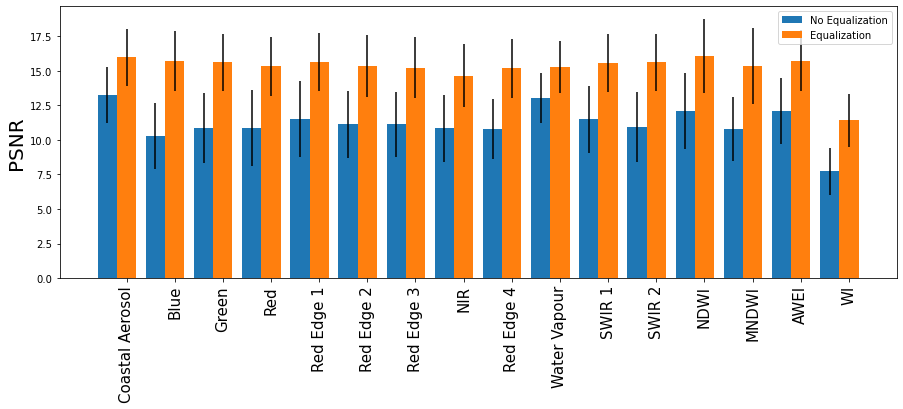

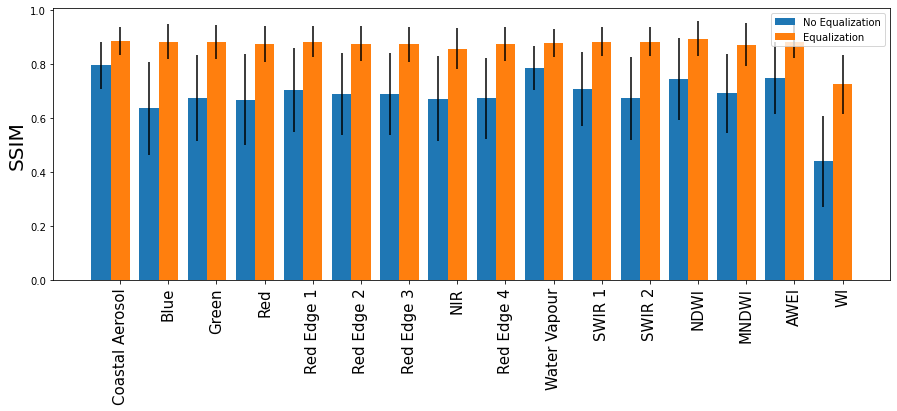

In [90]:
#Fig. 8. Average PSNR for Canny edge detection with and without histogram equalization

# Compare histogram equalization vs no equalization
df_all = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all_indices.csv",index_col=0)
df_blur = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_blur_indices.csv",index_col=0)
df_morph = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_morph_indices.csv",index_col=0)

mean_all = df_all[df_all.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_all = df_all[df_all.method=='canny'].groupby(["method","band"],as_index=False).std()

mean_blur = df_blur[df_blur.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_blur = df_blur[df_blur.method=='canny'].groupby(["method","band"],as_index=False).std()


bands = mean_all['band']

w= 0.8
metric = 'psnr'
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.bar(bands-w/2,mean_all[metric],yerr=sd_all[metric],width=w/2,label='No Equalization')
plt.bar(bands,mean_blur[metric],yerr=sd_blur[metric],width=w/2,label='Equalization')

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,17),labels= channels,fontsize=15, rotation=90)

plt.legend()
#plt.savefig(save_path.format("equalization_effect.png"),bbox_inches='tight')

w= 0.8
metric = 'ssim'
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.bar(bands-w/2,mean_all[metric],yerr=sd_all[metric],width=w/2,label='No Equalization')
plt.bar(bands,mean_blur[metric],yerr=sd_blur[metric],width=w/2,label='Equalization')

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,17),labels= channels,fontsize=15, rotation=90)

plt.legend()

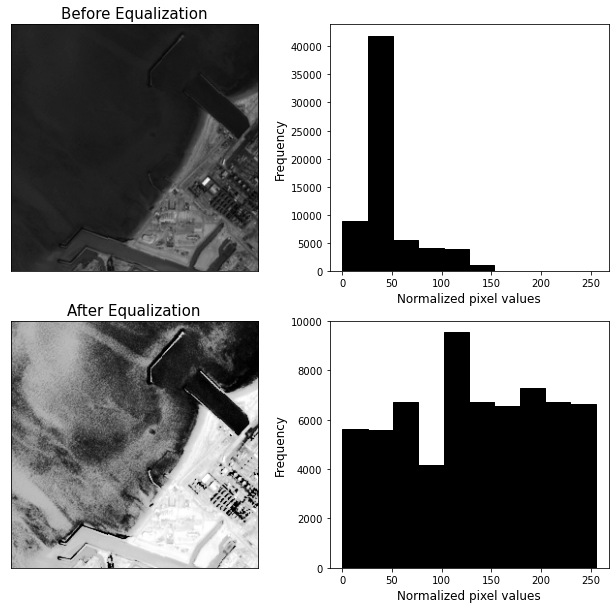

In [428]:
fig, axs = plt.subplots(2,2, figsize=(11,10))
rint= 60

#Before equalization
blue = channel_filter(input[rint],1)
blue = cv2.normalize(blue, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
axs[0,0].imshow(blue,cmap="gray")

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].set_title("Before Equalization",size=15)

axs[0,1].hist(blue.ravel(), fc='k', ec='k')
axs[0,1].set_xlabel("Normalized pixel values",size=12)
axs[0,1].set_ylabel("Frequency",size=12)

#After equalization
blue_hist = cv2.equalizeHist(blue)
axs[1,0].imshow(blue_hist,cmap="gray")
axs[1,0].set_xticks([])
axs[1,0].set_yticks([])
axs[1,0].set_title("After Equalization",size=15)

axs[1,1].hist(blue_hist.ravel(), fc='k', ec='k')
axs[1,1].set_xlabel("Normalized pixel values",size=12)
axs[1,1].set_ylabel("Frequency",size=12)

plt.savefig(save_path.format("histogram_equalization.png"),bbox_inches='tight')

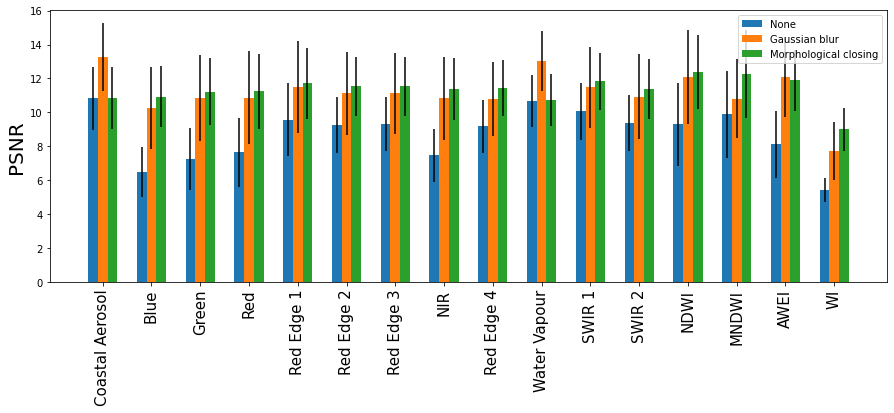

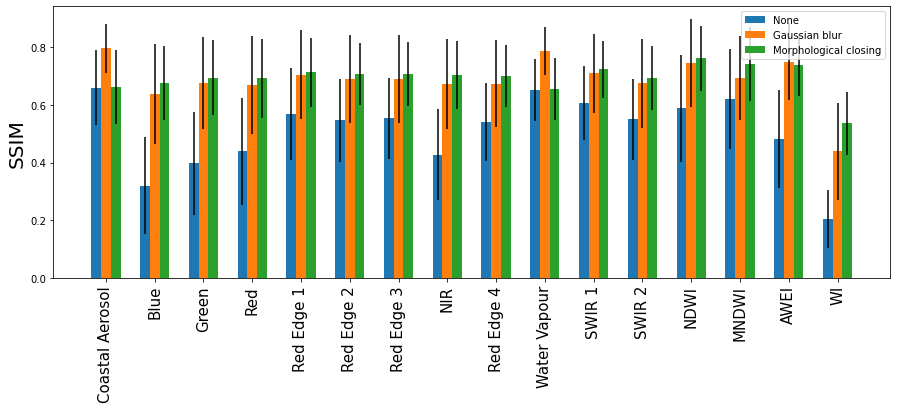

In [92]:
#Fig. 10. Average PSNR for canny edge detection using different noise reduction methods

# Determin impact of post processing
df_hist = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_hist_indices.csv",index_col=0) #no noise reduction
df_all = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all_indices.csv",index_col=0) #blur
df_morph = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_morph_indices.csv",index_col=0) #morph

mean_none = df_hist[df_hist.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_none = df_hist[df_hist.method=='canny'].groupby(["method","band"],as_index=False).std()

mean_blur = df_all[df_all.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_blur = df_all[df_all.method=='canny'].groupby(["method","band"],as_index=False).std()

mean_morph = df_morph[df_morph.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_morph = df_morph[df_morph.method=='canny'].groupby(["method","band"],as_index=False).std()

bands = mean_none['band']

w= 0.4
metric = 'psnr'
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.bar(bands-w/2,mean_none[metric],yerr=sd_none[metric],width=w/2,label='None')
plt.bar(bands,mean_blur[metric],yerr=sd_blur[metric],width=w/2,label='Gaussian blur')
plt.bar(bands+w/2,mean_morph[metric],yerr=sd_morph[metric],width=w/2,label='Morphological closing')

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,17),labels= channels,fontsize=15, rotation=90)

plt.legend()

#plt.savefig(save_path.format("effect_processing.png"),bbox_inches='tight')

w= 0.4
metric = 'ssim'
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.bar(bands-w/2,mean_none[metric],yerr=sd_none[metric],width=w/2,label='None')
plt.bar(bands,mean_blur[metric],yerr=sd_blur[metric],width=w/2,label='Gaussian blur')
plt.bar(bands+w/2,mean_morph[metric],yerr=sd_morph[metric],width=w/2,label='Morphological closing')

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,17),labels= channels,fontsize=15, rotation=90)

plt.legend()

# Archive

In [ ]:
# Thresholding and preprocessing experiments 
thresholds = [[50,100],[50,150],[100,200],[100,300],[200,400],[200,600]]
#toggles = [[True,False,False],[True,True,False],[True,False,True],[True,True,True]]
toggles = [[True,True,False]]

rows = []

for toggle in toggles:
    print(toggle)
    preprocess_input = input.copy()
    preprocess_input = [preprocess(img,toggle=toggle) for img in preprocess_input]

    for threshold in thresholds:
        print(threshold)

        t1 = threshold[0]
        t2 = threshold[1]
        canny = [canny_ed(img,threshold1=t1,threshold2=t2) for img in preprocess_input]
        
        for i in range(len(edge_reference)):
            ref_img = edge_reference[i]
            ID = "IMG#{}".format(i)
            
            for j in range(12):
                
                img = canny[i][:,:,j]

                rmse_ = rmse(ref_img,img)
                psnr_ = psnr(ref_img,img)
                uqi_ = uqi(ref_img,img)
                ssim_ = ssim(ref_img,img,multichannel=True)
                """ergas_ = ergas(ref_img,img)
                scc_ = scc(ref_img,img)
                sam_ = sam(ref_img,img)
                vifp_ = vifp(ref_img,img)"""

                row = [ID,str(threshold),str(toggle),j+ 1,rmse_,psnr_,uqi_,ssim_]
                rows.append(row)

    
df_metrics = pd.DataFrame(rows,columns = ['ID',"thresholds","toggle","band","rmse","psnr","uqi","ssim"])
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_canny.csv")
df_metrics.head()

In [ ]:
mean =  df_metrics[df_metrics.toggle=="[True, True, False]"].groupby(["thresholds","band"],as_index=False).mean()
sd =  df_metrics[df_metrics.toggle=="[True, True, False]"].groupby(["thresholds","band"],as_index=False).std()
metric = "psnr"
global channels

thresholds = [[50,100],[50,150],[100,200],[100,300],[200,400],[200,600]]
toggles = [[True,False,False],[True,True,False],[True,False,True],[True,True,True]]


fig,ax = plt.subplots(1,1,figsize=(15,5))

w = 0.4
for i,thresh in enumerate(thresholds):

    bands = mean[mean.thresholds==str(thresh)]["band"]

    mean_i = mean[mean.thresholds==str(thresh)][metric]
    sd_i = sd[sd.thresholds==str(thresh)][metric]
    
    plt.bar(bands-w/3+i*w/3,mean_i,yerr=sd_i,width=w/3,label=str(thresh))

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

plt.legend(title="Thresholds")


In [ ]:
preprocess_input = input.copy()
preprocess_input = [preprocess(img,toggle=[True,True,False]) for img in preprocess_input]

rint = random.randint(0,98)
print(rint)
rint=48
fig, axs = plt.subplots(1,3, figsize=(15,15))

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB image")

axs[1].imshow(labels[rint],cmap="gray")
axs[1].set_title("Label")

axs[2].imshow(255-edge_reference[rint],cmap="gray")
axs[2].set_title("Reference")


fig,axs = plt.subplots(2,3,figsize=(15,10))

for i,ax in enumerate(axs.flatten()):
    t1 = thresholds[i][0]
    t2 = thresholds[i][1]
    canny = [canny_ed(img,t1,t2) for img in preprocess_input][rint][:,:,1]
    psnr_ = psnr(edge_reference[rint],canny)
    ax.imshow(255-canny,cmap="gray")
    ax.set_title("Thresholds=({},{}) PSNR={:.2f}".format(t1,t2,psnr_))

In [ ]:
rint = random.randint(0,98)
print(rint)


preprocess_input = input.copy()
preprocess_input = [preprocess(img,toggle=[True,True,False]) for img in preprocess_input]


r = edge_reference[rint]*1.0
print(r.min(),r.max())

c = 2
canny = [canny_ed(img) for img in preprocess_input][rint][:,:,c]*1.0
print(canny.min(),canny.max())

non_edge =  np.array(canny)-np.array(r)
non_edge = np.clip(non_edge,0,255)
print(non_edge.min(),non_edge.max())

edge = np.clip(non_edge,0,255)-np.array(canny)
print(edge.min(),edge.max())

fig, axs = plt.subplots(1,5, figsize=(15,15))

axs[0].imshow(rgb[rint])

axs[1].imshow(255-r,cmap="gray")
axs[1].set_title("Reference")
axs[2].imshow(255-canny,cmap="gray")
axs[2].set_title("Canny Edge Detection")
axs[3].imshow(255-non_edge,cmap="gray")
axs[3].set_title("Not edges")
axs[4].imshow(edge,cmap="gray")
axs[4].set_title("Edges")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])